# Descargar los dataset

In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Suban el kaggle.json que obtienes al sacar una key API o algo así en Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0


In [ ]:
!unzip game-recommendations-on-steam.zip

Archive:  game-recommendations-on-steam.zip
  inflating: games.csv               
  inflating: games_metadata.json     
  inflating: recommendations.csv     
  inflating: users.csv               


# Abrir los CSV descargados

Tenemos 4 archivos en lo que descargamos, games.csv con información de los juegos, recommendations.csv que es si un usuario recomendo un juego o no y users.csv que salen todos los usuarios con la cantidad de productos que han comprado y la cantidad de reviews hechas. También, se tiene games_metadata con diferente información sobre los juegos.

In [ ]:
import pandas as pd

games = pd.read_csv("games.csv")
recommendations = pd.read_csv("recommendations.csv")
users = pd.read_csv("users.csv")

print(len(games))
print(len(recommendations))
print(len(users))


FileNotFoundError: [Errno 2] No such file or directory: 'games.csv'

Veamos los dataset y contemos usuarios únicos y juegos únicos en sus respectivos dataset y en el dataset de recomendaciones

In [ ]:
games.head()

NameError: name 'games' is not defined

In [ ]:
recommendations.head()

app_id  helpful  funny        date  is_recommended  hours  user_id  \
0   975370        0      0  2022-12-12            True   36.3    51580   
1   304390        4      0  2017-02-17           False   11.5     2586   
2  1085660        2      0  2019-11-17            True  336.5   253880   
3   703080        0      0  2022-09-23            True   27.4   259432   
4   526870        0      0  2021-01-10            True    7.9    23869   

   review_id  
0          0  
1          1  
2          2  
3          3  
4          4

In [ ]:
users.head()

user_id  products  reviews
0   7360263       359        0
1  14020781       156        1
2   8762579       329        4
3   4820647       176        4
4   5167327        98        2

In [ ]:
print(len(set((users["user_id"]))))

14306064


In [ ]:
print(len(set((games["app_id"]))))

50872


In [ ]:
print(len(set(recommendations["user_id"])))

In [ ]:
print(len(set(recommendations["app_id"])))

Dado que son muchos usuarios y recomendaciones, vamos a filtrar por los usuarios con más reviews en el dataset. Con una cantidad de 100 quiedan 8364 usuarios, 1539390 de recomendaciones y 35032 juegos.

In [ ]:
users_reviews = users[users["reviews"] >= 100]

In [ ]:
print(len(users_reviews))

8364


In [ ]:
filter_rec = recommendations[recommendations["user_id"].isin(users_reviews["user_id"])]

In [ ]:
print(len(filter_rec))

1539390


In [ ]:
#  Cuantos juegos quedan luego de haber filtrado por los usuarios con mas de 100 reviews
print(len(set(filter_rec["app_id"])))

35032


Ahora, filtramos los juegos para que solo estén aquellos que si tienen recomendaciones en el dataset respectivo

In [ ]:
filter_games = games[games["app_id"].isin(filter_rec["app_id"])]

In [ ]:
print(len(set(filter_games["app_id"])))

35032


Por último, se vuelven .csv cada dataframe, debido a que para resultados preliminares se trabajaran con estos en lugar del dataset completo que tiene millones de usuarios y recomendaciones. Todo esto, porque la alta cantidad de datos dificulta del entrenamiento por tiempo de ejecución y la memoria limitada de colab

In [ ]:
filter_games.to_csv('filter_games.csv', index=False)
users_reviews.to_csv('filter_users.csv', index=False)

In [ ]:
# Tuve que usar GPT para saber como descargarlo que habían problemas, porque tenía muchas filas
filter_rec.to_csv('filter_recommendations.csv.zip', index=False, compression='zip')

from google.colab import files
files.download('filter_recommendations.csv.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Análisis de datos

In [ ]:
games = pd.read_csv("filter_games.csv")
recommendations = pd.read_csv("filter_recommendations.csv", low_memory=False)
users = pd.read_csv("filter_users.csv")


In [ ]:
len(set(recommendations["app_id"]))

35032

Se creará un diccionario con la transformación cualitativa a cuantitativa del ranking.

In [ ]:
rating_mapping = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4.5,
    'Mostly Positive': 4,
    'Positive': 3.5,
    'Mixed': 3,
    'Mostly Negative': 2,
    'Negative': 1.5,
    'Very Negative': 1,
    'Overwhelmingly Negative': 0.5
}

Aplicando rating numérico.

In [ ]:
games['numeric_rating'] = games['rating'].map(rating_mapping)

Unir rating numérico a las recomendaciones.

In [ ]:
recommendations = recommendations.merge(games[['app_id', 'numeric_rating']], on='app_id', how='left')

Luego:

In [ ]:
from sklearn.model_selection import train_test_split

train = []
val = []

for user_id, group in recommendations.groupby("user_id"):
    if len(group) < 2:
        continue
    train_group, val_group = train_test_split(group, test_size=0.2, random_state=42)
    train.append(train_group)
    val.append(val_group)

recommendations_train = pd.concat(train)
recommendations_val = pd.concat(val)


In [ ]:
# Filtrar para que todos los juegos e usuarios en val estén en train
valid_users = set(recommendations_train['user_id'])
valid_items = set(recommendations_train['app_id'])

recommendations_val = recommendations_val[
    recommendations_val['user_id'].isin(valid_users) &
    recommendations_val['app_id'].isin(valid_items)
]

In [ ]:
print(len(recommendations_train))
print(len(recommendations_val))

1228168
310423


In [ ]:
users_train = recommendations_train['user_id'].nunique()
game_train = recommendations_train['app_id'].nunique()
review_train = len(recommendations_train)

print(f"El df de entrenamiento tiene {users_train} usuarios, {game_train} juegos y {review_train} reviews.")

El df de entrenamiento tiene 8364 usuarios, 34388 juegos y 1228168 reviews.


In [ ]:
users_val = recommendations_val['user_id'].nunique()
game_val = recommendations_val['app_id'].nunique()
review_val = len(recommendations_val)

print(f"El df de validación tiene {users_val} usuarios, {game_val} juegos y {review_val} reviews.")

El df de validación tiene 8364 usuarios, 26382 juegos y 310423 reviews.


In [ ]:
users_train_mean = recommendations_train.groupby('user_id')['review_id'].count().mean()
game_train_mean = recommendations_train.groupby('app_id')['review_id'].count().mean()

print(f"El promedio de reviews por usuario en el df de entrenamiento es {users_train_mean}.")
print(f"El promedio de reviews por juego en el df de entrenamiento es {game_train_mean}.")

El promedio de reviews por usuario en el df de entrenamiento es 146.83978957436634.
El promedio de reviews por juego en el df de entrenamiento es 35.715016866348726.


In [ ]:
users_val_mean = recommendations_val.groupby('user_id')['review_id'].count().mean()
game_val_mean = recommendations_val.groupby('app_id')['review_id'].count().mean()

print(f"El promedio de reviews por usuario en el df de validación es {users_val_mean}.")
print(f"El promedio de reviews por juego en el df de validación es {game_val_mean}.")

El promedio de reviews por usuario en el df de validación es 37.114179818268774.
El promedio de reviews por juego en el df de validación es 11.766469562580548.


In [ ]:
positive_recommendations_train = recommendations_train[recommendations_train['is_recommended'] == True]
negative_recommendations_train = recommendations_train[recommendations_train['is_recommended'] == False]

positive_percentage_train = (len(positive_recommendations_train) / len(recommendations_train)) * 100
negative_percentage_train = (len(negative_recommendations_train) / len(recommendations_train)) * 100

print(f"Porcentaje de recomendaciones positivas en recommendations_train: {positive_percentage_train:.2f}%")
print(f"Porcentaje de recomendaciones negativas en recommendations_train: {negative_percentage_train:.2f}%")

positive_recommendations_val = recommendations_val[recommendations_val['is_recommended'] == True]
negative_recommendations_val = recommendations_val[recommendations_val['is_recommended'] == False]

positive_percentage_val = (len(positive_recommendations_val) / len(recommendations_val)) * 100
negative_percentage_val = (len(negative_recommendations_val) / len(recommendations_val)) * 100

print(f"Porcentaje de recomendaciones positivas en recommendations_val: {positive_percentage_val:.2f}%")
print(f"Porcentaje de recomendaciones negativas en recommendations_val: {negative_percentage_val:.2f}%")


Porcentaje de recomendaciones positivas en recommendations_train: 77.97%
Porcentaje de recomendaciones negativas en recommendations_train: 22.03%
Porcentaje de recomendaciones positivas en recommendations_val: 78.08%
Porcentaje de recomendaciones negativas en recommendations_val: 21.92%


In [ ]:
user_max_ratings_train = recommendations_train.groupby('user_id')['review_id'].count().max()
user_max_ratings_validation = recommendations_val.groupby('user_id')['review_id'].count().max()

print(f"El usuario con más review en el df de entrenamiento tiene {user_max_ratings_train} reviews.")
print(f"El usuario con más review en el df de validación tiene {user_max_ratings_validation} reviews.")

El usuario con más review en el df de entrenamiento tiene 4836 reviews.
El usuario con más review en el df de validación tiene 1190 reviews.


In [ ]:
juego_max_ratings_train = recommendations_train.groupby('app_id')['review_id'].count().max()
juego_max_ratings_validation = recommendations_val.groupby('app_id')['review_id'].count().max()

print(f"El juego con más reviews en el df de entrenamiento tiene {juego_max_ratings_train} reviews.")
print(f"El juego con más reviews en el df de validación tiene {juego_max_ratings_validation} reviews.")

El juego con más reviews en el df de entrenamiento tiene 1972 reviews.
El juego con más reviews en el df de validación tiene 541 reviews.


In [ ]:
users_train = recommendations_train['user_id'].nunique()
juego_train = recommendations_train['app_id'].nunique()
review_train = len(recommendations_train)

train_density = (review_train / (users_train * juego_train))*100
aprox_train_density = round(train_density, 3)

print(f"La densidad del df de entrenamiento es de {aprox_train_density}%")

La densidad del df de entrenamiento es de 0.427%


In [ ]:
users_val = recommendations_val['user_id'].nunique()
juego_val = recommendations_val['app_id'].nunique()
review_val = len(recommendations_val)

val_density = (review_val / (users_val * juego_val))*100
aprox_val_density = round(val_density, 3)

print(f"La densidad del df de validación es de {aprox_val_density}%")

La densidad del df de validación es de 0.141%


In [ ]:
games_metadata = pd.read_json("games_metadata.json", lines=True)
print(len(games_metadata))

50872


In [ ]:
games_metadata.head(10)

app_id                                        description  \
0   13500  Enter the dark underworld of Prince of Persia ...   
1   22364                                                      
2  113020  Monaco: What's Yours Is Mine is a single playe...   
3  226560  Escape Dead Island is a Survival-Mystery adven...   
4  249050  Dungeon of the Endless is a Rogue-Like Dungeon...   
5  250180  “METAL SLUG 3”, the masterpiece in SNK’s emble...   
6  253980  Experience incredibly atmospheric and intense ...   
7  271850                                                      
8  282900  Packed with fast-paced, turn-based RPG action,...   
9   19810  Lead a team of domestic counter-terrorism expe...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]  
2  [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
3  [Zombies, Adventure, Survival, Action, Third P...  
4  [Roguelike, Strategy, Tower Defense, Pixel Gra...  
5  [Arcade, Classic, Action, Co-op, Side Scroller...  
6  [RPG, Action, Fantasy, Third Person, Hack and ...  
7  [Strategy, Simulation, Action, RTS, World War II]  
8  [Anime, JRPG, Female Protagonist, Cute, RPG, S...  
9                                 [Action, Tactical]

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Hecho exclusivamente con IA
# Solo aplicar ast.literal_eval si es string
def parse_tags(tags):
    if isinstance(tags, str):
        try:
            return ast.literal_eval(tags)
        except:
            return []
    return tags  # Ya es lista

# Aplicamos la función segura
games_metadata['tags'] = games_metadata['tags'].apply(parse_tags)

# Aplanar todos los tags en una sola lista
all_tags = [tag for tags_list in games_metadata['tags'] for tag in tags_list]

# Contar frecuencia de cada tag
tag_counts = Counter(all_tags)

# Obtener los 20 más comunes
most_common_tags = tag_counts.most_common(20)

# Separar para graficar
tags, counts = zip(*most_common_tags)

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(tags, counts, color='mediumseagreen')
plt.title('Top 20 tags más comunes en juegos')
plt.xlabel('Tag')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
rating_counts = games['rating'].value_counts(normalize=True) * 100

# Gráfico de barras
plt.figure(figsize=(12, 6))
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribución porcentual de ratings en videojuegos")
plt.xlabel("Rating")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

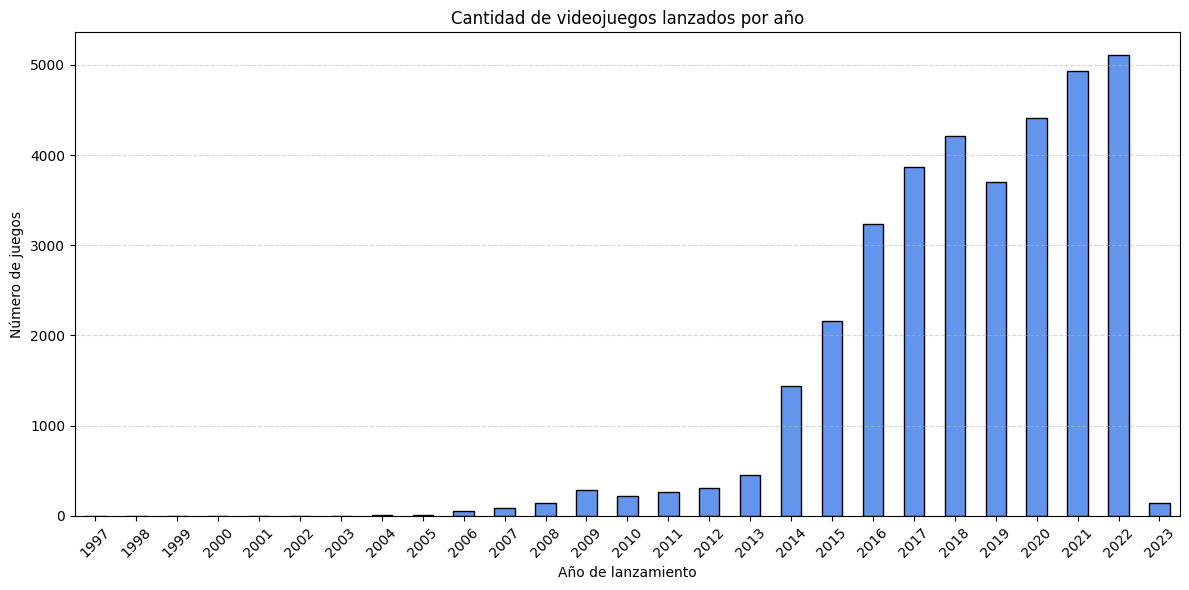

In [ ]:
games['date_release'] = pd.to_datetime(games['date_release'], errors='coerce')
games_valid = games.dropna(subset=['date_release'])

# Obtener el año
games_valid['release_year'] = games_valid['date_release'].dt.year

# Contar juegos por año
year_counts = games_valid['release_year'].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Cantidad de videojuegos lanzados por año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Número de juegos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

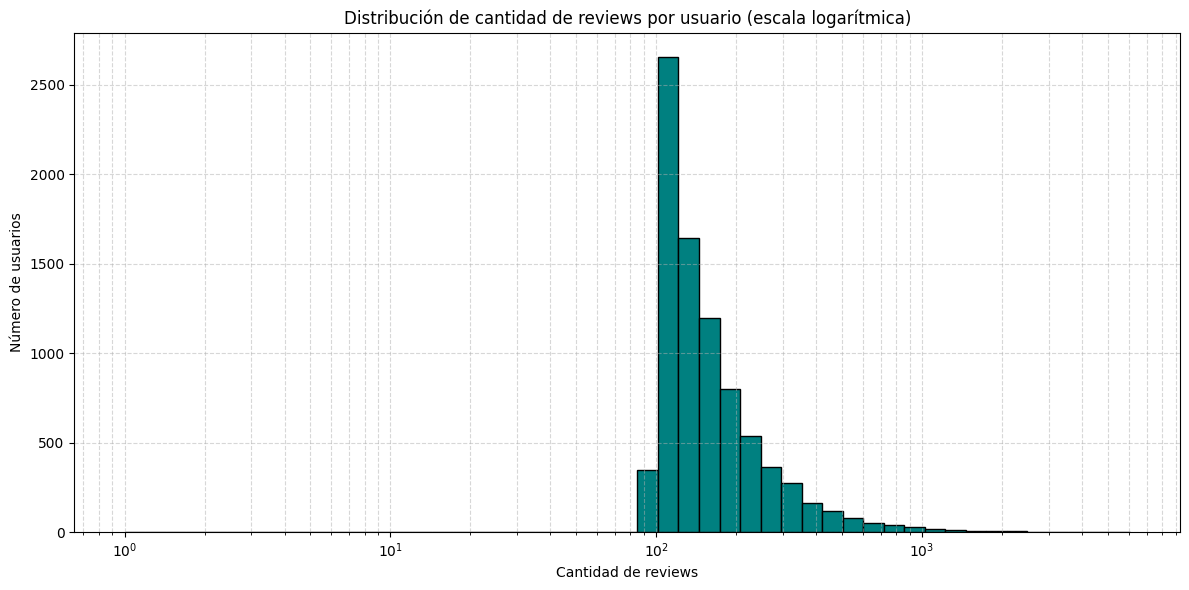

In [ ]:
import numpy as np

# Eliminar valores nulos o negativos
users_clean = users[users['reviews'] > 0]

# Histograma con bins logarítmicos
plt.figure(figsize=(12, 6))
plt.hist(users_clean['reviews'], bins=np.logspace(0, np.log10(users_clean['reviews'].max()), 50),
         color='teal', edgecolor='black')
plt.xscale('log')
plt.title('Distribución de cantidad de reviews por usuario (escala logarítmica)')
plt.xlabel('Cantidad de reviews')
plt.ylabel('Número de usuarios')
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Modelos

## ***Random***

Vamos a crear una clase para el sistema de recomendación Random

In [ ]:
class RandomRecommender:
    def __init__(self, items):
        self.items = items

    def recommend(self, user_id, n=5):
        return np.random.choice(self.items, size=n, replace=False).tolist()

Creando lista única de juegos, en base al conjunto de entrenamiento.

In [ ]:
unique_games = recommendations_train['app_id'].unique()

Procesando el modelo.

In [ ]:
# Inicializando modelo con lista de juegos únicos
random_recommender = RandomRecommender(unique_games)

Ahora, se definirán las métricas de evaluación (Recall@10, MAP@10 y nDCG@10).

In [ ]:
def recall_at_k(recommended_items, relevant_items, k=10):
    recommended_at_k = set(recommended_items[:k])
    relevant_items = set(relevant_items)
    return len(recommended_at_k & relevant_items) / len(relevant_items) if relevant_items else 0

def map_at_k(recommended_items, relevant_items, k=10):
    relevant_items = set(relevant_items)
    score = 0
    num_hits = 0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            num_hits += 1
            score += num_hits / (i + 1)
    return score / min(len(relevant_items), k) if relevant_items else 0

def ndcg_at_k(recommended_items, relevant_items, k=10):
    def dcg(rel):
        return sum((2**rel_i - 1) / np.log2(i + 2) for i, rel_i in enumerate(rel))

    relevant_items = set(relevant_items)
    rel_vector = [1 if item in relevant_items else 0 for item in recommended_items[:k]]
    ideal_rel_vector = sorted(rel_vector, reverse=True)
    return dcg(rel_vector) / dcg(ideal_rel_vector) if dcg(ideal_rel_vector) > 0 else 0

Una vez definidos los cálculos, se procederá a hacer el cálculo sobre el conjunto de validación.

In [ ]:
recall_scores = []
map_scores = []
ndcg_scores = []

for user_id, group in recommendations_val.groupby("user_id"):
    relevant_items = group['app_id'].tolist()
    recommended_items = random_recommender.recommend(user_id, n=10)

    recall_scores.append(recall_at_k(recommended_items, relevant_items, k=10))
    map_scores.append(map_at_k(recommended_items, relevant_items, k=10))
    ndcg_scores.append(ndcg_at_k(recommended_items, relevant_items, k=10))

# Calculando las métricas promedio
average_recall = np.mean(recall_scores)
average_map = np.mean(map_scores)
average_ndcg = np.mean(ndcg_scores)

#Imprimiendo resultados
print(f"Recall@10: {average_recall:.4f}")
print(f"MAP@10: {average_map:.4f}")
print(f"nDCG@10: {average_ndcg:.4f}")

Recall@10: 0.0003
MAP@10: 0.0003
nDCG@10: 0.0053


## ***Most Popular***

Vamos a implementar el modelo *Most Popular*.

In [ ]:
most_popular_items = recommendations.groupby('app_id').size().reset_index(name='interaction_count')

# Se ordenarán los juegos por popularidad, y se les asignará un ranking
most_popular_items = most_popular_items.sort_values(by='interaction_count', ascending=False)
most_popular_items['rank'] = range(1, len(most_popular_items) + 1)

# Mapeando los nombres de los juegos
most_popular_items = most_popular_items.merge(games[['app_id', 'title']], on='app_id', how='left')

Creando función para ejecutar el modelo

In [ ]:
def recommend_most_popular(n=10):
    return most_popular_items.head(n)['app_id'].tolist()

Se procederá a crear una función para calcular los indicadores para el modelo *Most Popular*.

In [ ]:
def evaluate_metrics(recommendations_val, top_n=10):
    metrics = {
        "MAP@10": [],
        "nDCG@10": [],
        "Recall@10": []
    }

    # Iterando sobre cada usuario en el conjunto de validación
    for user_id, group in recommendations_val.groupby("user_id"):
        relevant_items = group['app_id'].tolist()

        recommended_items = recommend_most_popular(top_n)

        metrics["MAP@10"].append(map_at_k(recommended_items, relevant_items, k=top_n))
        metrics["nDCG@10"].append(ndcg_at_k(recommended_items, relevant_items, k=top_n))
        metrics["Recall@10"].append(recall_at_k(recommended_items, relevant_items, k=top_n))

    # Promediando métricas
    metrics = {key: np.mean(values) for key, values in metrics.items()}
    return metrics

Evaluando las métricas en el conjunto de validación.

In [ ]:
metrics = evaluate_metrics(recommendations_val, top_n=10)
print("Métricas de evaluación:")
print(f"MAP@10: {metrics['MAP@10']:.4f}")
print(f"nDCG@10: {metrics['nDCG@10']:.4f}")
print(f"Recall@10: {metrics['Recall@10']:.4f}")

Métricas de evaluación:
MAP@10: 0.0203
nDCG@10: 0.2027
Recall@10: 0.0177


## ***Item-based Collaborative Filtering***

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

Primero, vamos a tomar una muestra y reobtener los conjuntos de entrenamiento y de prueba, debido a que son muchos datos, y este proceso se demoraría mucho tiempo en llegar a un resultado.

In [ ]:
sample_size_games = 1000
sample_size_recommendations = 5000
sample_size_users = 1000

Para obtener una muestra, vamos a configurar una función que se encargue de realizarlo.

In [ ]:
def sample_data(data, sample_size, random_state=42):
    return data.sample(sample_size, random_state=random_state) if len(data) > sample_size else data

In [ ]:
games_IBCF = sample_data(games, sample_size_games)
recommendations_IBCF = sample_data(recommendations, sample_size_recommendations)
users_IBCF = sample_data(users, sample_size_users)

In [ ]:
train_IBCF = []
val_IBCF = []

for user_id, group in recommendations_IBCF.groupby("user_id"):
    if len(group) < 2:
        continue
    train_group, val_group = train_test_split(group, test_size=0.2, random_state=42)
    train_IBCF.append(train_group)
    val_IBCF.append(val_group)

recommendations_train_IBCF = pd.concat(train_IBCF)
recommendations_val_IBCF = pd.concat(val_IBCF)

# Filtrar para que todos los juegos y usuarios en val estén en train
valid_users_IBCF = set(recommendations_train_IBCF['user_id'])
valid_items_IBCF = set(recommendations_train_IBCF['app_id'])

recommendations_val_IBCF = recommendations_val_IBCF[
    recommendations_val_IBCF['user_id'].isin(valid_users_IBCF) &
    recommendations_val_IBCF['app_id'].isin(valid_items_IBCF)
]

Ahora, para implementar este modelo, debemos crear una matriz usuario-ítem. Para esto, se creará una función encargada de su cálculo.

In [ ]:
def create_user_item_matrix(train_data):
    user_item_matrix = train_data.pivot_table(index='user_id', columns='app_id', values='numeric_rating', fill_value=0)
    return user_item_matrix

Implementando la función.

In [ ]:
user_item_matrix = create_user_item_matrix(recommendations_train_IBCF)

Definiendo el cálculo de las similitudes entre ítems.

In [ ]:
def calculate_item_similarity(user_item_matrix):
    scaler = StandardScaler()
    item_matrix_scaled = scaler.fit_transform(user_item_matrix.T)  # Transpuesta para similitud entre ítems
    item_similarity = cosine_similarity(item_matrix_scaled)
    similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
    return similarity_df

Implementando función de cálculo de similitudes.

In [ ]:
item_similarity_df = calculate_item_similarity(user_item_matrix)

Vamos a generar funciones encargadas de predecir ratings y de realizar recomendaciones.

In [ ]:
def predict_ratings(user_id, user_item_matrix, item_similarity_df):
    user_ratings = user_item_matrix.loc[user_id]
    predicted_scores = item_similarity_df.dot(user_ratings).div(item_similarity_df.sum(axis=1))
    return predicted_scores

def recommend_items(user_id, user_item_matrix, item_similarity_df, top_n=10):
    predicted_scores = predict_ratings(user_id, user_item_matrix, item_similarity_df)

    user_rated_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    predicted_scores = predicted_scores.drop(user_rated_items)

    top_items = predicted_scores.nlargest(top_n).index.tolist()
    return top_items

Se implementará una función encargada del cálculo de las métricas.

In [ ]:
def evaluate_model(recommendations_val, user_item_matrix, item_similarity_df, k=10):
    recall_scores = []
    map_scores = []
    ndcg_scores = []

    for user_id in recommendations_val['user_id'].unique():
        relevant_items = recommendations_val[recommendations_val['user_id'] == user_id]['app_id'].tolist()
        if user_id not in user_item_matrix.index:
            continue

        recommended_items = recommend_items(user_id, user_item_matrix, item_similarity_df, top_n=k)

        recall_scores.append(recall_at_k(recommended_items, relevant_items, k))
        map_scores.append(map_at_k(recommended_items, relevant_items, k))
        ndcg_scores.append(ndcg_at_k(recommended_items, relevant_items, k))

    return {
        'Recall@10': np.mean(recall_scores),
        'MAP@10': np.mean(map_scores),
        'nDCG@10': np.mean(ndcg_scores)
    }

Finalmente:

In [ ]:
if __name__ == "__main__":
    metrics = evaluate_model(recommendations_val_IBCF, user_item_matrix, item_similarity_df, k=10)
    print("Evaluación del modelo:")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")

Evaluación del modelo:
Recall@10: 0.0042
MAP@10: 0.0007
nDCG@10: 0.0015
